## **`Breast Cancer Detection` - Kaggle Style ML Notebook**

In [ ]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score


In [4]:
# 2. Load Dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

df.sample(5)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
80,11.45,20.97,73.81,401.5,0.11020,0.09362,0.04591,0.02233,0.1842,0.07005,...,32.16,84.53,525.1,0.1557,0.1676,0.17550,0.06127,0.2762,0.08851,1
320,10.25,16.18,66.52,324.2,0.10610,0.11110,0.06726,0.03965,0.1743,0.07279,...,20.61,71.53,390.4,0.1402,0.2360,0.18980,0.09744,0.2608,0.09702,1
448,14.53,19.34,94.25,659.7,0.08388,0.07800,0.08817,0.02925,0.1473,0.05746,...,28.39,108.10,830.5,0.1089,0.2649,0.37790,0.09594,0.2471,0.07463,1
239,17.46,39.28,113.40,920.6,0.09812,0.12980,0.14170,0.08811,0.1809,0.05966,...,44.87,141.20,1408.0,0.1365,0.3735,0.32410,0.20660,0.2853,0.08496,0
303,10.49,18.61,66.86,334.3,0.10680,0.06678,0.02297,0.01780,0.1482,0.06600,...,24.54,70.76,375.4,0.1413,0.1044,0.08423,0.06528,0.2213,0.07842,1


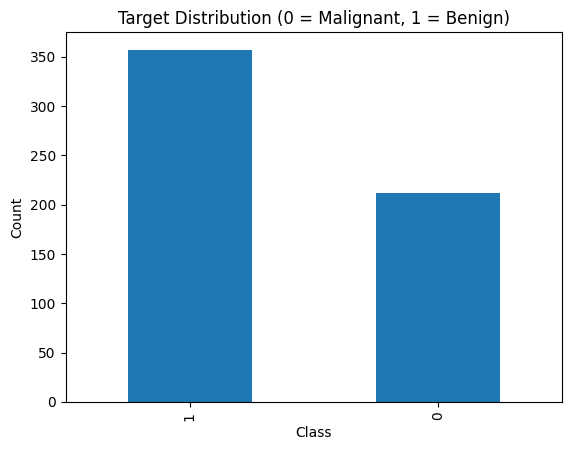

In [5]:
# 3. Target Distribution (EDA)
plt.figure()
df["target"].value_counts().plot(kind="bar")
plt.title("Target Distribution (0 = Malignant, 1 = Benign)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


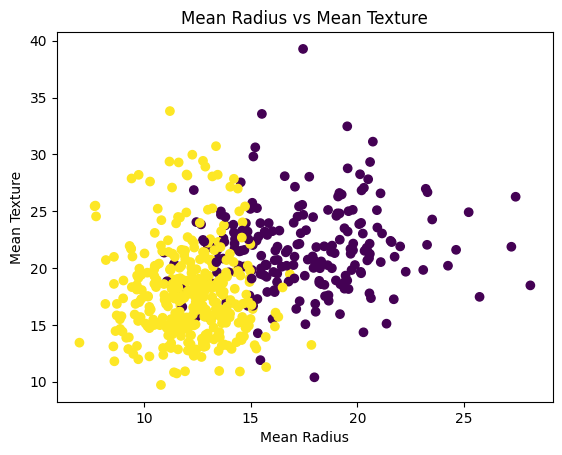

In [6]:
# 5. Correlation Insight (EDA)
plt.figure()
plt.scatter(df["mean radius"], df["mean texture"], c=df["target"])
plt.xlabel("Mean Radius")
plt.ylabel("Mean Texture")
plt.title("Mean Radius vs Mean Texture")
plt.show()


In [7]:
# 6. Create Categorical Features (for encoding demonstration)

# Ordinal feature
df["tumor_size_category"] = pd.cut(
    df["mean radius"],
    bins=[0, 12, 18, 30],
    labels=["Small", "Medium", "Large"]
)

# Nominal feature
df["texture_type"] = np.where(
    df["mean texture"] > df["mean texture"].median(),
    "Rough",
    "Smooth"
)

df[["tumor_size_category", "texture_type"]].head()


,tumor_size_category,texture_type
0,Medium,Smooth
1,Large,Smooth
2,Large,Rough
3,Small,Rough
4,Large,Smooth


In [8]:
# 7. Split Data
X = df.drop("target", axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# 8. Column Types
numerical_features = X.select_dtypes(include=np.number).columns
ordinal_features = ["tumor_size_category"]
nominal_features = ["texture_type"]

# Ordinal order
tumor_order = [["Small", "Medium", "Large"]]

# 9. Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("ord", OrdinalEncoder(categories=tumor_order), ordinal_features),
        ("nom", OneHotEncoder(handle_unknown="ignore"), nominal_features)
    ]
)


In [ ]:
# 10. Models + Model Selection

import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge (L2)": LogisticRegression(penalty="l2", max_iter=1000),
    "Lasso (L1)": LogisticRegression(penalty="l1", solver="saga", max_iter=1000),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

best_model = None
best_model_name = None
best_accuracy = 0.0

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    pipe = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])
    
    # Cross-validation
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5).mean()
    print("CV Accuracy:", cv_score)
    
    # Train
    pipe.fit(X_train, y_train)
    
    # Test
    y_pred = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", test_acc)
    
    # Track best model
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        best_model = pipe
        best_model_name = name

# 11. Save Best Model

joblib.dump(best_model, "best_breast_cancer_model.pkl")

print("\n==============================")
print("Best Model:", best_model_name)
print("Best Test Accuracy:", best_accuracy)
print("Model saved as: best_breast_cancer_model.pkl")



===== Logistic Regression =====
CV Accuracy: 0.9780219780219781
Test Accuracy: 0.9736842105263158

===== Ridge (L2) =====
CV Accuracy: 0.9780219780219781
Test Accuracy: 0.9736842105263158

===== Lasso (L1) =====


c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

CV Accuracy: 0.9736263736263737


c:\Users\ok\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Test Accuracy: 0.9824561403508771

===== SVM =====
CV Accuracy: 0.9714285714285715
Test Accuracy: 0.9736842105263158

===== KNN =====
CV Accuracy: 0.964835164835165
Test Accuracy: 0.9736842105263158

===== Decision Tree =====
CV Accuracy: 0.9208791208791208
Test Accuracy: 0.9122807017543859

===== Random Forest =====
CV Accuracy: 0.9582417582417582
Test Accuracy: 0.9473684210526315

Best Model: Lasso (L1)
Best Test Accuracy: 0.9824561403508771
Model saved as: best_breast_cancer_model.pkl
